In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.datasets import load_iris
import cvxopt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
%matplotlib inline

Loading Iris dataset

In [2]:
iris = load_iris()

In [3]:
df = pd.DataFrame(data=iris.data, columns= iris.feature_names)

In [4]:
# store mapping of targets and target names
target_dict = dict(zip(set(iris.target), iris.target_names))

# add the target labels and the feature names
df["target"] = iris.target
df["target_names"] = df.target.map(target_dict)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


Now we set X and y vectors of our code. To show that this data is linearly separable, we plotted a scatter of two features with their labels. 

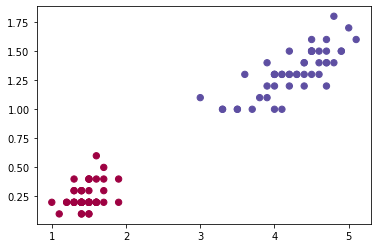

100


In [5]:
# setting X and y  
X = df.query("target_names == 'setosa' or target_names == 'versicolor'").loc[:, "petal length (cm)":"petal width (cm)"] 
y = df.query("target_names == 'setosa' or target_names == 'versicolor'").loc[:, "target"]
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()
print(len(X))

__Primal formulation__


In [6]:
z = np.zeros((3,3))
for i in range(2):
    z[i][i] = 1
P = cvxopt_matrix(z, tc='d')

In [7]:
q = np.zeros(3)
q[0:3] = 0
q = cvxopt_matrix(q,tc='d')

In [8]:
final = []

for i in range(len(y)):
    if y.iloc[i] == 0:
        y.iloc[i] = -1
    temp = list(-y.iloc[i] * X.iloc[i])
    temp.append(y.iloc[i] * 1.0)
    final.append(temp)
G = cvxopt_matrix(np.array(final))

<ipython-input-8-bada9395c354>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.iloc[i] = -1
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
temp = np.ones((100,1))*-1
# temp = np.concatenate((temp, np.zeros((40,1))))
h = cvxopt_matrix(temp, tc='d')

In [10]:
cvxopt_solvers.options['maxiters'] = 150

In [11]:
sol = cvxopt_solvers.qp(P,q,G,h)

     pcost       dcost       gap    pres   dres
 0:  2.0420e-01  1.4894e+01  3e+02  2e+00  2e+02
 1:  1.7498e+00 -2.7759e+01  4e+01  3e-01  3e+01
 2:  1.8727e+00 -2.5337e+00  5e+00  2e-02  3e+00
 3:  1.1942e+00  5.7960e-01  6e-01  8e-04  9e-02
 4:  1.2979e+00  7.9137e-01  5e-01  4e-04  5e-02
 5:  1.1784e+00  1.1578e+00  2e-02  1e-05  1e-03
 6:  1.1765e+00  1.1763e+00  2e-04  1e-07  1e-05
 7:  1.1765e+00  1.1765e+00  2e-06  1e-09  1e-07
 8:  1.1765e+00  1.1765e+00  2e-08  1e-11  1e-09
Optimal solution found.


In [12]:
print(sol['x'][0:3]) #weights

[ 1.29e+00]
[ 8.24e-01]
[ 3.79e+00]



[ 3.02857145 -0.11428572 -3.25714288]
[ 4.24285717  1.1        -2.04285717]
[ 1.81428573 -1.32857144 -4.4714286 ]


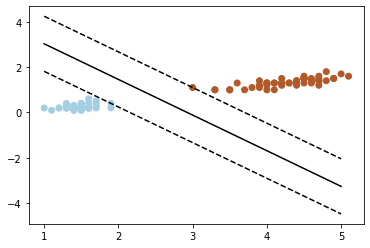

In [13]:
x = np.linspace(1, 5, 3)
yy1 = -(sol['x'][0]) / sol['x'][1] * x + (sol['x'][2]) / sol['x'][1]
yy_up = (-(sol['x'][0]) * x + (sol['x'][2]) + 1) / sol['x'][1]
print(yy1)
print(yy_up)
yy_down = (-(sol['x'][0]) * x + (sol['x'][2]) - 1)/ sol['x'][1]
print(yy_down)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Paired)
plt.plot(x,yy1,'k-')
plt.plot(x,yy_up,'k--')
plt.plot(x,yy_down,'k--')

__Dual formulation__


In [14]:
def linear_kernel(x_i,x_j):
    return np.dot(x_i,x_j)

In [15]:
n_samples, n_feats = X.shape

K = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        K[i][j] = linear_kernel(X.iloc[i], X.iloc[j])

In [16]:
C = 1
m, n = X.shape
M = y[:, None] * X

P = cvxopt_matrix(np.outer(y, y) * K)

q = cvxopt_matrix(-np.ones((m, 1)))

G = cvxopt_matrix(np.identity(m) * -1.0)

h = cvxopt_matrix(np.zeros(n_samples), tc='d')

A = cvxopt_matrix(y, (1, m),tc='d')

b = cvxopt_matrix(np.zeros(1))
# find the solution
cvxopt_solvers.options['show_progress'] = False
solution = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(solution['x'])


In [17]:
w = np.array([0.0,0.0])

for i in range(m):
    w = w + alphas[i] * y[i] * X.iloc[i]
print(w)

petal length (cm)    1.294118
petal width (cm)     0.823529
dtype: float64


In [18]:

b = 0
count = 0
for i in range(m):
    if alphas[i] > 10**-5:
        b = b - y[i] + np.dot(np.transpose(w),X.iloc[i])
        count += 1
b = b/count
print(b)

3.7882353007257494


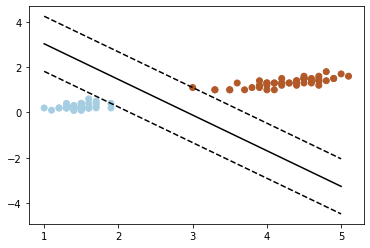

In [20]:
x = np.linspace(1, 5, 30)
yy1 = -(w[0]) /w[1] * x + b / w[1]
yy_up = (-(w[0]) * x + (b) + 1) / w[1]
yy_down = (-(w[0]) * x + (b) - 1)/ w[1]
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Paired)
plt.plot(x,yy1,'k-')
plt.plot(x,yy_up,'k--')
plt.plot(x,yy_down,'k--')